In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import os

Ex1

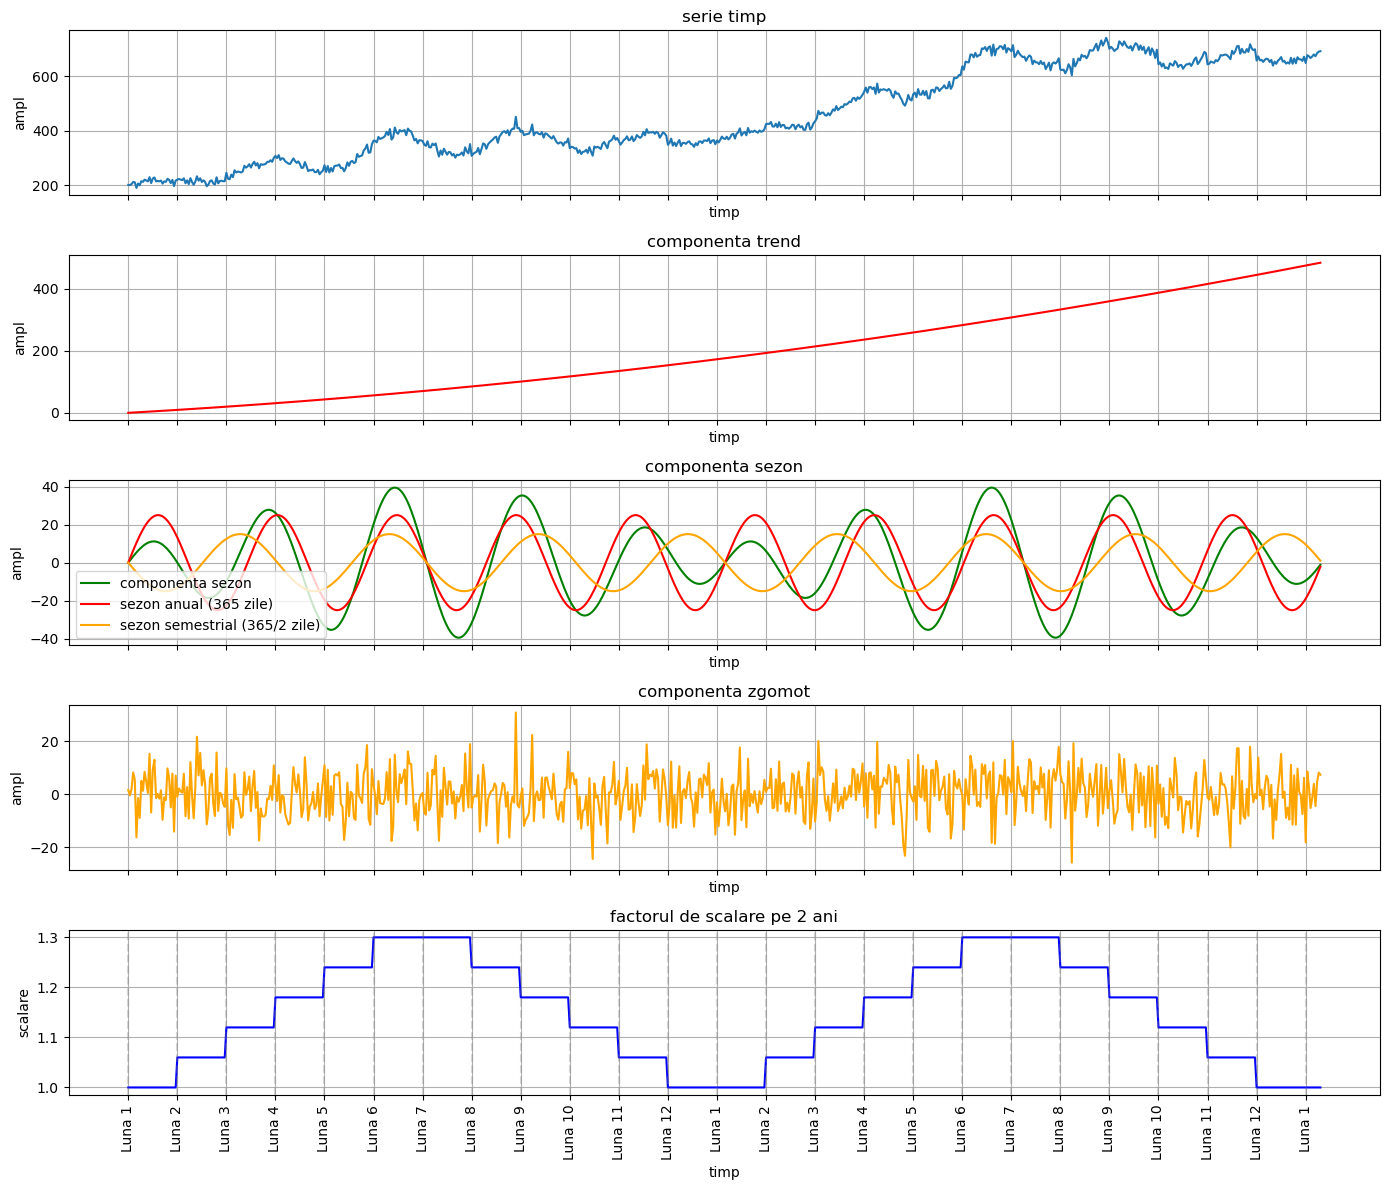

In [2]:
# a) e stabilit ca sezonul e o functie sezoniera care trebuie sa aiba in componenta ei doua frecvente, iar trend-ul e o ec polinomiala
# i will quote my own repo de unde iau o idee de time series
# https://github.com/andialexandrescu/Seasonal_Sales_Predictor_OracleAI23/blob/main/generare_seasonal_time_series_vanzari.sql
os.makedirs("./lab8_plots/ex1", exist_ok=True)

# interpretez seria de timp a unor vanzari timp de trei ani, fiind indexul fiecarei zile
# vreau vanzarile sa creasca in prima parte a anului, dupa aceea sa scada treptat
# intervalul de timp t pe care voi descrie seria de timp e de 2 ani
N = 365*2
t = np.arange(N)
zile_pe_luna = 30
luna = (t//zile_pe_luna)%12+1
#  if luna < 7
#             then
#                 scalare := 1.0 + (luna-1) * (0.3/5);-- prima jum a anului inseamna o crestere de la 1.0 la 1.3
#             else
#                 scalare := 1.3 - (luna-7) * (0.3/5);-- o scadere de la 1.3 la 1.0
#             end if;
scalare = np.zeros_like(luna, dtype=float)
scalare[luna<7] = 1.0 + (luna[luna<7] - 1) * (0.3/5)
scalare[luna>=7] = 1.3 - (luna[luna>=7] - 7) * (0.3/5)

# factor_sezonier := ampl_sezonier * sin(2*acos(-1)*index_zi/365);-- acos(-1) = pi, codif zilelor dintr-un an, totusi trebuie impartit la nr de zile care completeaza ciclul
#             -- SAU V2: https://skforecast.org/0.10.0/faq/cyclical-features-time-series
#             -- signal_1 = 3 + 4 * sin(index_zi/365*2*acos(-1))
#             -- signal_2 = 3 * sin(index_zi/365*4*acos(-1)+365/2)
#             zgomot := zgomot_std * dbms_random.normal;
    
#             -- additive + multiplicative time series
#             aux_vanzari_zilnice := (nivel_baza + factor_sezonier + zgomot) * scalare;

nivel_baza = 200 # nivel de baza stabilit in proiectul meu anterior pentru date de vanzari care sa nu scada sub acest prag
# nivel_baza number default 200,
factor_trend = 0.0005*t**2+0.3*t

ampl_sezonier_1 = 25 # amplificator sezonier, cat de mult variatia sezoniera poate sa scada/ creasca
ampl_sezonier_2 = 15
frecv_1 = 5
frecv_2 = 2
factor_sezonier_1 = ampl_sezonier_1 * np.sin(2*np.pi*t*frecv_1/365)
factor_sezonier_2 = ampl_sezonier_2 * np.sin(2*np.pi*t*frecv_2/(365/2)+np.pi) # defazaj
factor_sezonier = factor_sezonier_1+factor_sezonier_2

zgomot_std = 8
zgomot = zgomot_std*np.random.randn(N)

serie_timp = (nivel_baza+factor_trend+factor_sezonier+zgomot)*scalare

fig, axs = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

axs[0].plot(t, serie_timp)
axs[0].set_title('serie timp')
axs[0].set_xlabel('timp')
axs[0].set_ylabel('ampl')
axs[0].grid(True)

axs[1].plot(t, factor_trend, color='red')
axs[1].set_title('componenta trend')
axs[1].set_xlabel('timp')
axs[1].set_ylabel('ampl')
axs[1].grid(True)

axs[2].plot(t, factor_sezonier, color='green', label='componenta sezon')
axs[2].plot(t, factor_sezonier_1, color='red', label='sezon anual (365 zile)')
axs[2].plot(t, factor_sezonier_2, color='orange', label='sezon semestrial (365/2 zile)')
axs[2].set_title('componenta sezon')
axs[2].set_xlabel('timp')
axs[2].set_ylabel('ampl')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(t, zgomot, color='orange')
axs[3].set_title('componenta zgomot')
axs[3].set_xlabel('timp')
axs[3].set_ylabel('ampl')
axs[3].grid(True)

axs[4].plot(t, scalare, color='blue', label='factor scalare')
axs[4].set_title('factorul de scalare pe 2 ani')
axs[4].set_xlabel('timp')
axs[4].set_ylabel('scalare')
axs[4].grid(True)

# din lab5
nr_luni = 24
L_tick_luna = [i*zile_pe_luna for i in range(nr_luni+1)]
L_label_luna = [f'Luna {((i)%12)+1}' for i in range(nr_luni+1)]
axs[4].set_xticks(L_tick_luna)
axs[4].set_xticklabels(L_label_luna, rotation=90)
for tick in L_tick_luna:
    axs[4].axvline(x=tick, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(f"lab8_plots/ex1/generare_serie_timp.pdf", format="pdf")
plt.show()

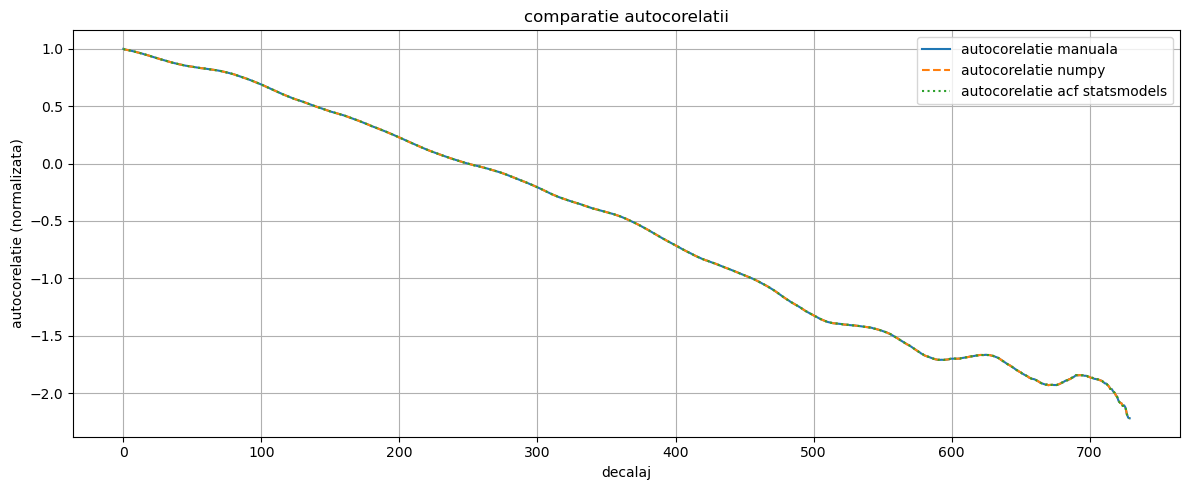

In [3]:
# b) comparatie autocorelatii
# din curs, impartire la N-k, deoarece estimarea ar fi corecta pentru orice decalaj

# pastrez doar decalajele pozitive de la 0 la N-1
# acestea arata cum se coreleaza seria de timp cu ea insasi deplasata spre dreapta
# adica se masoara similaritatea intre valorile curente si cele din trecut la diferite decalaje
# decalajele pt k>0 arata o asociere a seriei cu ea insasi deplasata la k pasi in timp
decalaje = np.arange(0, N)

ac_manuala = np.zeros(N)
for k in range(N):
    ac_manuala[k] = np.sum((serie_timp[:N-k]-np.mean(serie_timp))*(serie_timp[k:]-np.mean(serie_timp)))/(N-k)
ac_manuala = ac_manuala/ac_manuala[0] # normalizare la decalaj=0

aux_ac = np.correlate(serie_timp-np.mean(serie_timp), serie_timp-np.mean(serie_timp), mode='full')
aux_ac = aux_ac[N-1:] # decalaje pozitive
ac_numpy = np.zeros(N)
for k in range(N):
    ac_numpy[k] = aux_ac[k]/(N-k)
ac_numpy = ac_numpy/ac_numpy[0] # normalizare la decalaj=0

ac_statsmodels = acf(serie_timp, nlags=N-1, fft=True, adjusted=True)

plt.figure(figsize=(12, 5))
plt.plot(decalaje, ac_manuala, label='autocorelatie manuala')
plt.plot(decalaje, ac_numpy, '--', label='autocorelatie numpy')
plt.plot(decalaje, ac_statsmodels, ':', label='autocorelatie acf statsmodels')
plt.title('comparatie autocorelatii')
plt.xlabel('decalaj')
plt.ylabel('autocorelatie (normalizata)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lab8_plots/ex1/comparatie_autocorelatii.pdf', format='pdf')
plt.show()

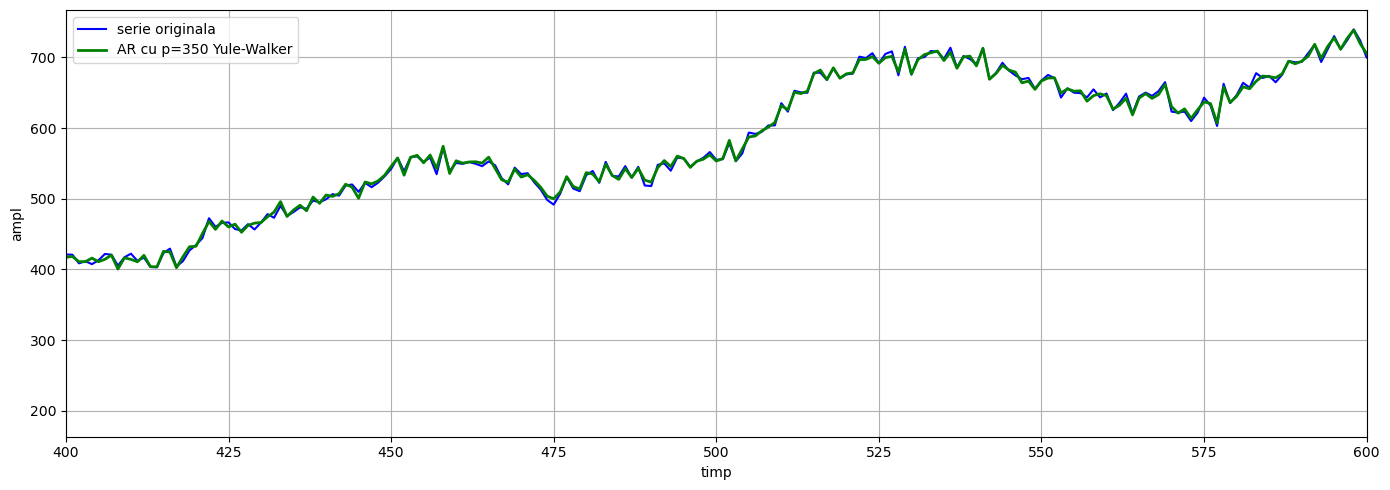

In [4]:
# c) model AR estimat manual cu ec Yule-Walker

p = 350
m = N-p # diferenta dintre lungimea seriei totale si dimensiunea modelului AR

Y = serie_timp[p:] # m x 1 valori de prezis
X = np.column_stack([serie_timp[p-i:N-i] for i in range(1, p+1)]) # m x p decalaje

YTY = X.T@X # p x p matricea corelatiei
YTy = X.T@Y # p x 1 vectorul gamma mic transpus

x = np.linalg.solve(YTY, YTy) # solutie Yule-Walker (Y^TY)x = Y^Ty, nici nu e nevoie de inversare pt ca numpy got your back
Y_pred = X@x

plt.figure(figsize=(14, 5))
t = np.arange(N)
t_pred = np.arange(p, N)
plt.plot(t, serie_timp, color='blue', label='serie originala')
plt.plot(t_pred, Y_pred, color='green', label=f'AR cu p={p} Yule-Walker', lw=2)
plt.xlabel('timp')
plt.ylabel('ampl')
plt.legend()
plt.grid(True)
plt.xlim(400, 600)
plt.tight_layout()
plt.savefig('lab8_plots/ex1/modelul_AR_p_15.pdf', format='pdf')
plt.show()


p in intervalul [1,29] de pas 1
m in intervalul [182,482] de pas 60
p=10, m=422, mse cross-validation=144.47
mse test=190.3897502477177


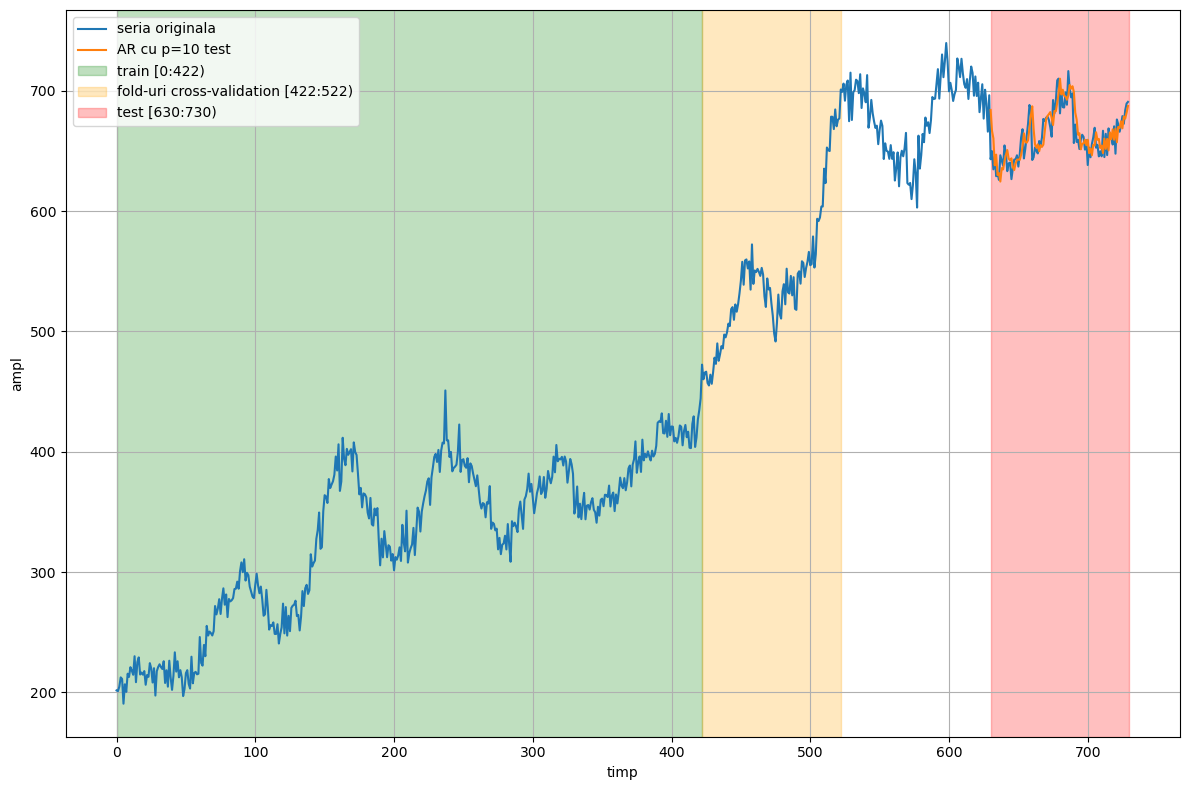

In [5]:
# d)
# daca as incerca sa fac hypertune la parametrii in functie de partea testare pe un set de date in intervalul de timp imediat urmator dupa cel de antrenare,
# as descoperi ca descopera pattern-uri recente aplicabile pe setul de date respectiv, insa rezultatele pentru p si m nu ar fi cele real performante
# deci aplic cross-validation cu 5 n_splits impreuna cu o parcurgere a tuturor combinatiilor de perechi (p, m)

dim_validare = 100
dim_test = 100
poz_start_test = N-dim_test # testez pe ultimele 100 de puncte intre N-dim_test si N

L_p = np.arange(1, 30, 1) # lista valori p
L_m = np.arange(N//4, poz_start_test-dim_validare, N//12) # lista valori m
print(f"p in intervalul [{L_p[0]},{L_p[-1]}] de pas 1")
print(f"m in intervalul [{L_m[0]},{L_m[-1]}] de pas {N//12}")

cross_val = TimeSeriesSplit(n_splits=5) # cross-validation
min_scor_cross_val, p_, m_ = float('inf'), None, None

for p in L_p:
    for m in L_m:
        if m <= p:
            continue
        
        L_cross_val_mse = []
        for train_index, val_index in cross_val.split(np.arange(m)): # fold curent intre 0 si m
            
            # date antrenare pt fold
            poz_fin_train = train_index[-1]+1
            Y_train = serie_timp[p:poz_fin_train] # poz_fin_train-p x 1 vector target
            # var 2 pt model AR manual
            X_train = np.column_stack([serie_timp[p-i:poz_fin_train-i] for i in range(1,p+1)]) # poz_fin_train-p x p matrice elem predicted

            coef = np.linalg.lstsq(X_train, Y_train, rcond=None)[0] # metoda least squares
            
            # predictie utimele 100 de puncte
            poz_fin_val = min(poz_fin_train+dim_validare, m)
            L_pred = [np.dot(coef, serie_timp[t-p:t][::-1]) for t in range(poz_fin_train, poz_fin_val)]
            L_actual = serie_timp[poz_fin_train:poz_fin_val]
            mse = mean_squared_error(L_actual, L_pred)
            L_cross_val_mse.append(mse)
                    
        
        if len(L_cross_val_mse) > 0:
            mean_cv_mse = np.mean(L_cross_val_mse)
            if mean_cv_mse < min_scor_cross_val:
                min_scor_cross_val = mean_cv_mse
                p_, m_ = p, m

print(f"p={p_}, m={m_}, mse cross-validation={min_scor_cross_val:.2f}")

# reantrenare pe tot intervalul incepand cu max_m
poz_fin_retrain = m_+dim_validare
if poz_fin_retrain > poz_start_test:
    poz_fin_retrain = poz_start_test

Y_train_final = serie_timp[p_:poz_fin_retrain]
X_train_final = np.column_stack([serie_timp[p_-i:poz_fin_retrain-i] for i in range(1,p_+1)])
final_coef = np.linalg.lstsq(X_train_final, Y_train_final, rcond=None)[0]

L_pred_test = [np.dot(final_coef, serie_timp[t-p_:t][::-1]) for t in range(poz_start_test, N)]
mse_test = mean_squared_error(serie_timp[poz_start_test:N], L_pred_test)
print(f"mse test={mse_test}")

plt.figure(figsize=(12, 8))
plt.plot(t, serie_timp, label='seria originala')
plt.plot(range(poz_start_test, N), L_pred_test, label=f'AR cu p={p_} test')

plt.axvspan(0, m_, color='green', alpha=0.25, label=f'train [0:{m_})')
plt.axvspan(m_, poz_fin_retrain, color='orange', alpha=0.25, label=f'fold-uri cross-validation [{m_}:{poz_fin_retrain})')
plt.axvspan(poz_start_test, N, color='red', alpha=0.25, label=f'test [{poz_start_test}:{N})')
plt.xlabel('timp')
plt.ylabel('ampl')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(f"lab8_plots/ex1/ar_hypertuning.pdf", format="pdf")
plt.show()